<a href="https://colab.research.google.com/github/Andres8bit/Machine-Learning/blob/main/Image_Super_Resolution_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [173]:
import os
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import  load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from IPython.display import display 
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL

In [174]:
# Utility Functions 
def plot_results(img,prefix, title):
  img_array = img_to_array(img)
  img_array = img_array.astype("float32") / 255.0

  fig, ax = plt.subplots()
  im = ax.imshow(img_array[::-1],origin="lower")
  plt.title(title)

  axins = zoomed_inset_axes(ax,2,loc=2)
  axins.imshow(img_array[::-1],origin="lower")

  x1,x2,y1,y2 = 200,300,100,200
  axins.set_xlim(x1,x2)
  axins.set_ylim(y1,y2)
  plt.yticks(visible=False)
  plt.xticks(visible=False)
  mark_inset(ax,axins,loc1=1,loc2=3,fc="none",ec="blue")
  plt.savefig(str(prefix) + "-" + title + ".png")
  plt.show()

def get_lowres_image(img,upscale_factor):
  return img.resize(
        (img.size[0] // upscale_factor, img.size[1] //upscale_factor),
        PIL.Image.BICUBIC,
    )

def upscale_image(model,img):
  ycbcr = img.convert("YCbCr")
  y, cb, cr = ycbcr.split()
  y = img_to_array(y)
  y = y.astype("float32") / 255.0

  input = np.expand_dims(y,axis=0)
  out = model.predict(input)

  out_img_y = out[0]
  out_img_y *= 255.0

  out_img_y = out_img_y.clip(0,255)
  out_img_y = out_img_y.reshape((np.shape(out_img_y)[0],np.shape(out_img_y)[1]))
  out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
  out_img_cb = cb.resize(out_img_y.size,PIL.Image.BICUBIC)
  out_img_cr = cr.resize(out_img_y.size,PIL.Image.BICUBIC)
  out_img = PIL.Image.merge("YCbCr", (out_img_y,out_img_cb,out_img_cr)).convert("RGB")

  return out_img

In [175]:
def process_input(input,input_size,upscale_factor):
  input = tf.image.rgb_to_yuv(input)
  last_dimension_axis = len(input.shape) - 1
  y,u,v = tf.split(input,3,axis=last_dimension_axis)

  return tf.image.resize(y,[input_size,input_size],method="area")

def process_target(input):
  input = tf.image.rgb_to_yuv(input)
  last_dimension_axis = len(input.shape) - 1
  y, u, v = tf.split(input,3,axis=last_dimension_axis)

  return y



In [176]:
def get_model(upscale_factor=3,channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)

In [177]:
# Callback Class:
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[1]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 2 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))



In [178]:
# CheckPoints and EarlyStopping:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "/tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

In [179]:
dataset_url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
data_dir = keras.utils.get_file(origin=dataset_url, fname="BSR", untar=True)
root_dir = os.path.join(data_dir, "BSDS500/data")

In [180]:
crop_size = 300
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 8

training_set = image_dataset_from_directory(
    root_dir,
    batch_size = batch_size,
    image_size=(crop_size,crop_size),
    validation_split = 0.2,
    subset ="training",
    seed = 1337,
    label_mode = None
) 

valid_set = image_dataset_from_directory(root_dir,
                                         batch_size=batch_size,
                                         image_size=(crop_size,crop_size),
                                         validation_split=0.2,
                                         subset="validation",
                                         seed=1337,
                                         label_mode=None,  

                                        )

Found 500 files belonging to 1 classes.
Using 400 files for training.
Found 500 files belonging to 1 classes.
Using 100 files for validation.


In [181]:
def scaling(input_image):
  input_image = input_image/255.0
  return input_image


training_set = training_set.map(scaling)
valid_set = valid_set.map(scaling)

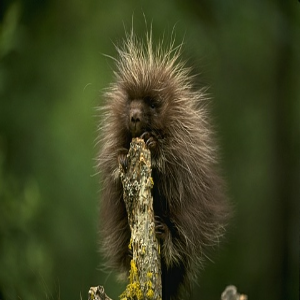

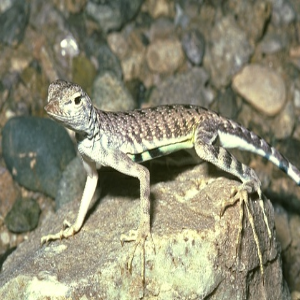

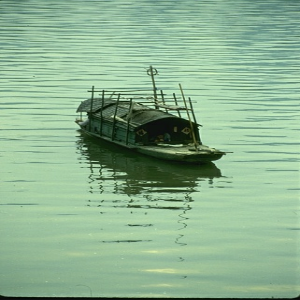

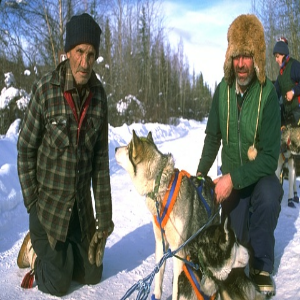

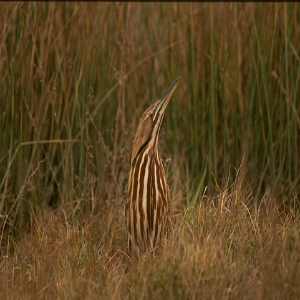

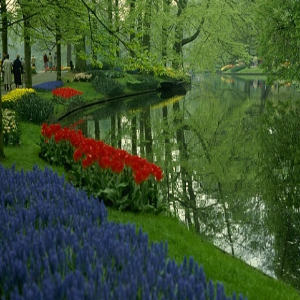

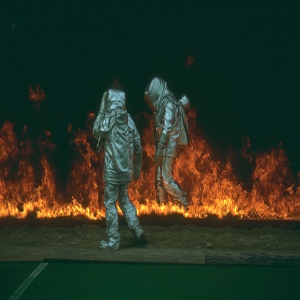

In [182]:
for batch in training_set.take(1):
  for img in batch:
    display(array_to_img(img))

In [183]:
dataset = os.path.join(root_dir,"images")
test_path = os.path.join(dataset,"test")
test_img_paths = sorted(
    [
     os.path.join(test_path,fname)
     for fname in os.listdir(test_path)
     if fname.endswith(".jpg")
    ]
)

In [184]:
training_set = training_set.map(
    lambda x: (process_input(x,input_size,upscale_factor), process_target(x))
)

training_set = training_set.prefetch(buffer_size=32)

valid_set = valid_set.map(
    lambda x: (process_input(x, input_size,upscale_factor), process_target(x))
)

valid_set = valid_set.prefetch(buffer_size=32)

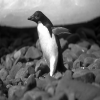

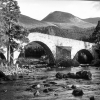

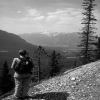

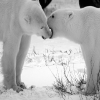

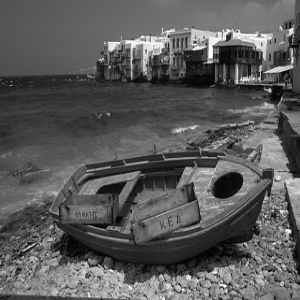

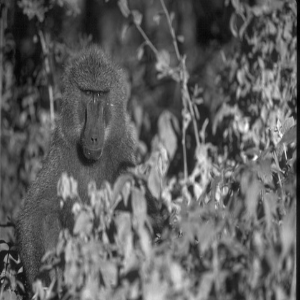

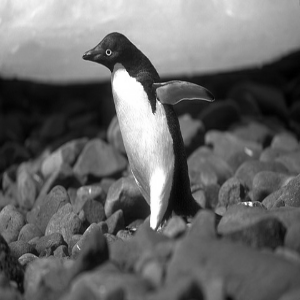

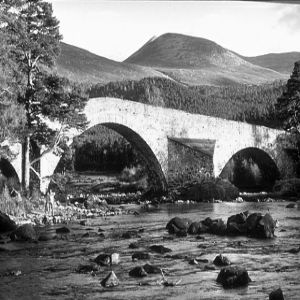

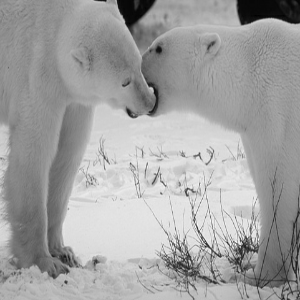

In [185]:
for batch in training_set.take(1):
  for img in batch[0]:
    display(array_to_img(img))
  for img in batch[1]:
    display(array_to_img(img))

In [186]:
model = get_model(upscale_factor=upscale_factor,channels=1)
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, None, None, 64)    1664      
_________________________________________________________________
conv2d_41 (Conv2D)           (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_42 (Conv2D)           (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_43 (Conv2D)           (None, None, None, 9)     2601      
_________________________________________________________________
tf.nn.depth_to_space_10 (TFO (None, None, None, 1)     0         
Total params: 59,657
Trainable params: 59,657
Non-trainable params: 0
______________________________________________________

In [187]:
callbacks = [ESPCNCallback(),early_stopping_callback,model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.01)

Epoch 1/100
50/50 - 2s - loss: 0.4141 - accuracy: 0.0032 - val_loss: 0.0078 - val_accuracy: 0.0028
Mean PSNR for epoch: 21.09


Epoch 2/100
50/50 - 2s - loss: 0.0078 - accuracy: 0.0033 - val_loss: 0.0066 - val_accuracy: 0.0028
Mean PSNR for epoch: 21.67
Epoch 3/100
50/50 - 2s - loss: 0.0066 - accuracy: 0.0033 - val_loss: 0.0053 - val_accuracy: 0.0028
Mean PSNR for epoch: 22.82


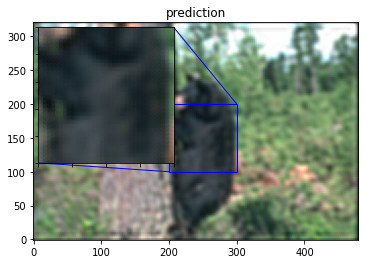

Epoch 4/100
50/50 - 2s - loss: 0.0055 - accuracy: 0.0033 - val_loss: 0.0044 - val_accuracy: 0.0028
Mean PSNR for epoch: 24.04
Epoch 5/100
50/50 - 2s - loss: 0.0049 - accuracy: 0.0033 - val_loss: 0.0045 - val_accuracy: 0.0028
Mean PSNR for epoch: 23.58


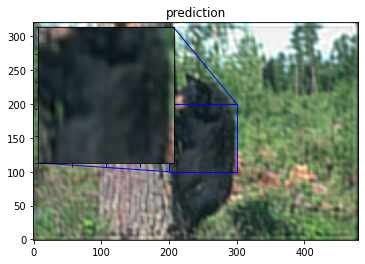

Epoch 6/100
50/50 - 2s - loss: 0.0047 - accuracy: 0.0033 - val_loss: 0.0037 - val_accuracy: 0.0028
Mean PSNR for epoch: 24.55
Epoch 7/100
50/50 - 2s - loss: 0.0039 - accuracy: 0.0033 - val_loss: 0.0033 - val_accuracy: 0.0028
Mean PSNR for epoch: 24.94


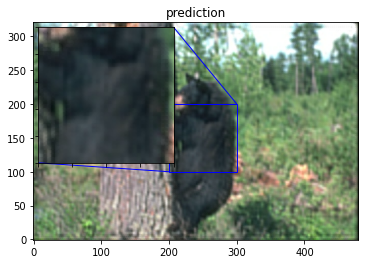

Epoch 8/100
50/50 - 2s - loss: 0.0037 - accuracy: 0.0033 - val_loss: 0.0030 - val_accuracy: 0.0028
Mean PSNR for epoch: 25.35
Epoch 9/100
50/50 - 2s - loss: 0.0035 - accuracy: 0.0033 - val_loss: 0.0034 - val_accuracy: 0.0028
Mean PSNR for epoch: 24.86


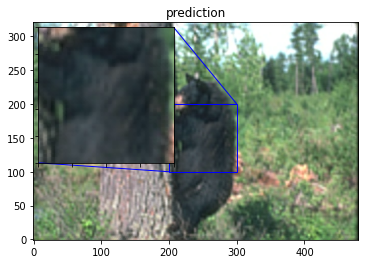

Epoch 10/100
50/50 - 2s - loss: 0.0034 - accuracy: 0.0033 - val_loss: 0.0030 - val_accuracy: 0.0028
Mean PSNR for epoch: 25.24
Epoch 11/100
50/50 - 2s - loss: 0.0033 - accuracy: 0.0033 - val_loss: 0.0030 - val_accuracy: 0.0028
Mean PSNR for epoch: 25.34


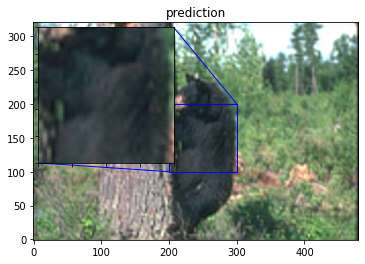

Epoch 12/100
50/50 - 2s - loss: 0.0033 - accuracy: 0.0033 - val_loss: 0.0034 - val_accuracy: 0.0028
Mean PSNR for epoch: 24.65
Epoch 13/100
50/50 - 2s - loss: 0.0032 - accuracy: 0.0033 - val_loss: 0.0027 - val_accuracy: 0.0028
Mean PSNR for epoch: 25.73


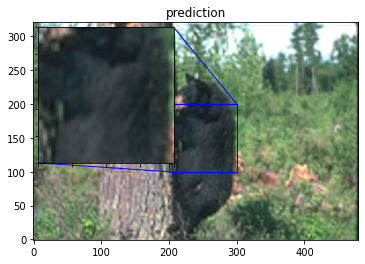

Epoch 14/100
50/50 - 2s - loss: 0.0032 - accuracy: 0.0033 - val_loss: 0.0027 - val_accuracy: 0.0028
Mean PSNR for epoch: 25.85
Epoch 15/100
50/50 - 2s - loss: 0.0031 - accuracy: 0.0033 - val_loss: 0.0027 - val_accuracy: 0.0028
Mean PSNR for epoch: 25.97


Epoch 16/100
50/50 - 2s - loss: 0.0032 - accuracy: 0.0033 - val_loss: 0.0028 - val_accuracy: 0.0028
Mean PSNR for epoch: 25.63
Epoch 17/100
50/50 - 2s - loss: 0.0031 - accuracy: 0.0033 - val_loss: 0.0027 - val_accuracy: 0.0028
Mean PSNR for epoch: 25.43


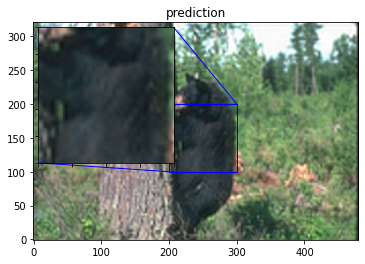

Epoch 18/100
50/50 - 2s - loss: 0.0031 - accuracy: 0.0033 - val_loss: 0.0034 - val_accuracy: 0.0028
Mean PSNR for epoch: 24.77
Epoch 19/100
50/50 - 2s - loss: 0.0033 - accuracy: 0.0033 - val_loss: 0.0026 - val_accuracy: 0.0028
Mean PSNR for epoch: 26.30


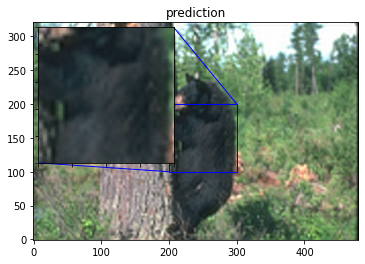

Epoch 20/100
50/50 - 2s - loss: 0.0032 - accuracy: 0.0033 - val_loss: 0.0034 - val_accuracy: 0.0028
Mean PSNR for epoch: 24.88
Epoch 21/100
50/50 - 2s - loss: 0.0032 - accuracy: 0.0033 - val_loss: 0.0026 - val_accuracy: 0.0028
Mean PSNR for epoch: 26.14


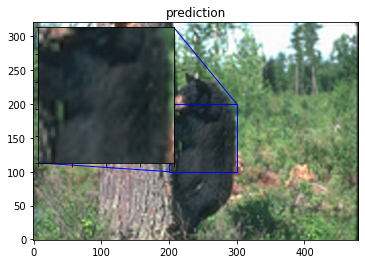

Epoch 22/100
50/50 - 2s - loss: 0.0029 - accuracy: 0.0033 - val_loss: 0.0025 - val_accuracy: 0.0028
Mean PSNR for epoch: 25.90
Epoch 23/100
50/50 - 2s - loss: 0.0029 - accuracy: 0.0033 - val_loss: 0.0025 - val_accuracy: 0.0028
Mean PSNR for epoch: 26.25


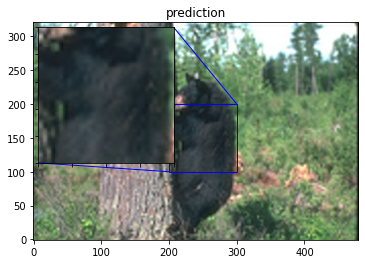

Epoch 24/100
50/50 - 2s - loss: 0.0033 - accuracy: 0.0033 - val_loss: 0.0031 - val_accuracy: 0.0028
Mean PSNR for epoch: 25.38
Epoch 25/100
50/50 - 2s - loss: 0.0031 - accuracy: 0.0033 - val_loss: 0.0027 - val_accuracy: 0.0028
Mean PSNR for epoch: 26.26


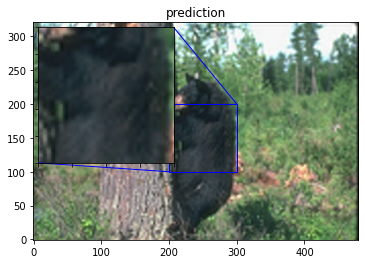

Epoch 26/100
50/50 - 2s - loss: 0.0029 - accuracy: 0.0033 - val_loss: 0.0025 - val_accuracy: 0.0028
Mean PSNR for epoch: 25.94
Epoch 27/100
50/50 - 2s - loss: 0.0028 - accuracy: 0.0033 - val_loss: 0.0025 - val_accuracy: 0.0028
Mean PSNR for epoch: 26.74


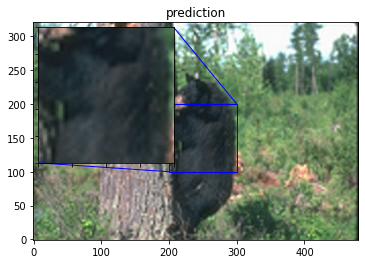

Epoch 28/100
50/50 - 2s - loss: 0.0028 - accuracy: 0.0033 - val_loss: 0.0026 - val_accuracy: 0.0028
Mean PSNR for epoch: 26.00
Epoch 29/100
50/50 - 2s - loss: 0.0029 - accuracy: 0.0033 - val_loss: 0.0025 - val_accuracy: 0.0028
Mean PSNR for epoch: 26.23


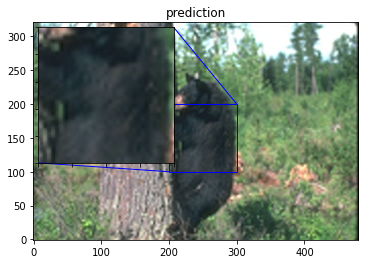

Epoch 30/100
50/50 - 2s - loss: 0.0028 - accuracy: 0.0033 - val_loss: 0.0025 - val_accuracy: 0.0028
Mean PSNR for epoch: 26.08
Epoch 31/100
50/50 - 2s - loss: 0.0032 - accuracy: 0.0033 - val_loss: 0.0029 - val_accuracy: 0.0028
Mean PSNR for epoch: 25.16


Epoch 32/100
50/50 - 2s - loss: 0.0033 - accuracy: 0.0033 - val_loss: 0.0028 - val_accuracy: 0.0028
Mean PSNR for epoch: 25.73
Epoch 33/100
50/50 - 2s - loss: 0.0029 - accuracy: 0.0033 - val_loss: 0.0025 - val_accuracy: 0.0028
Mean PSNR for epoch: 26.56


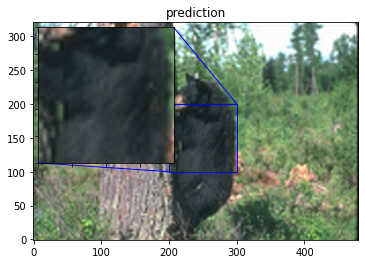

Epoch 34/100
50/50 - 2s - loss: 0.0028 - accuracy: 0.0033 - val_loss: 0.0025 - val_accuracy: 0.0028
Mean PSNR for epoch: 26.19
Epoch 35/100
50/50 - 2s - loss: 0.0028 - accuracy: 0.0033 - val_loss: 0.0027 - val_accuracy: 0.0028
Mean PSNR for epoch: 26.00


Epoch 36/100
50/50 - 2s - loss: 0.0030 - accuracy: 0.0033 - val_loss: 0.0029 - val_accuracy: 0.0028
Mean PSNR for epoch: 25.83
Epoch 37/100
50/50 - 2s - loss: 0.0030 - accuracy: 0.0033 - val_loss: 0.0035 - val_accuracy: 0.0028
Mean PSNR for epoch: 24.65


Epoch 38/100
50/50 - 2s - loss: 0.0029 - accuracy: 0.0033 - val_loss: 0.0025 - val_accuracy: 0.0028
Mean PSNR for epoch: 26.35
Epoch 39/100
50/50 - 2s - loss: 0.0029 - accuracy: 0.0033 - val_loss: 0.0029 - val_accuracy: 0.0028
Mean PSNR for epoch: 25.48


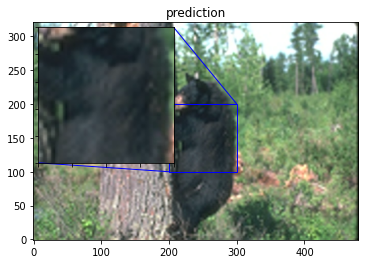

Epoch 40/100
50/50 - 2s - loss: 0.0028 - accuracy: 0.0033 - val_loss: 0.0025 - val_accuracy: 0.0028
Mean PSNR for epoch: 26.02
Epoch 41/100
50/50 - 2s - loss: 0.0032 - accuracy: 0.0033 - val_loss: 0.0029 - val_accuracy: 0.0028
Mean PSNR for epoch: 25.44


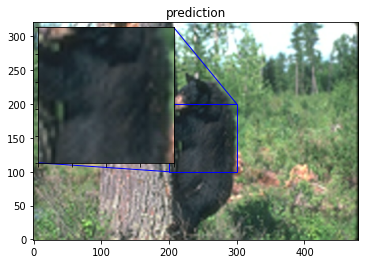

Epoch 42/100
50/50 - 2s - loss: 0.0032 - accuracy: 0.0033 - val_loss: 0.0025 - val_accuracy: 0.0028
Mean PSNR for epoch: 26.32
Epoch 43/100
50/50 - 2s - loss: 0.0028 - accuracy: 0.0033 - val_loss: 0.0025 - val_accuracy: 0.0028
Mean PSNR for epoch: 26.46


Epoch 44/100
50/50 - 2s - loss: 0.0028 - accuracy: 0.0033 - val_loss: 0.0025 - val_accuracy: 0.0028
Mean PSNR for epoch: 26.47


In [188]:
epochs = 100

model.compile(
    optimizer=optimizer,loss=loss_fn,metrics=['accuracy']
)

model.fit(training_set,epochs=epochs,callbacks=callbacks,
          validation_data=valid_set,verbose=2)
